## Figure 4

In [1]:
import mne
import numpy as np
import csv
from glob import glob
from tqdm.notebook import tqdm
import h5py
from scipy.spatial import ConvexHull
from matplotlib import pyplot as plt
from matplotlib import rcParams as rc
rc['pdf.fonttype'] = 42
plt.style.use('seaborn')
import sys
sys.path.append('../preprocessing/utils/')
import strf

In [2]:
# Change these path for running the notebook locally
eeg_data_path = '/path/to/dataset/' # downloadable from OSF: https://doi.org/10.17605/OSF.IO/FNRD9
git_path  = '/path/to/git/speaker_induced_suppression_EEG/'
# Where the output of train_linear_model.ipynb is saved. Run that first if you haven't already.
h5_path = '/path/to/h5/' 

In [3]:
perception_color = '#117733'
production_color = '#332288'
predictable_color = '#ddcc77'
unpredictable_color = '#aa4499'
picks = ['F1','Fz','F2','FC1','FCz','FC2','C1','Cz','C2']
tmin,tmax = -.3, .5
delays = np.arange(np.floor(tmin*128),np.ceil(tmax*128),dtype=int)
exclude = ['OP0001','OP0002','OP0020']
subjs = np.sort([s[-6:] for s in glob(f'{git_path}eventfiles/*') if 'OP0' in s and s[-6:] not in exclude])
models = ['model1','model1e','model2','model2e','model3','model3e','model4','model4e']
features = {model_number:strf.get_feats(model_number=model_number,extend_labels=True) for model_number in models}
n_feats = {model_number:len(features[model_number]) for model_number in models}

### Load data

In [4]:
# Load STRF data from hdf5
wts, corrs, pvals, sig_wts, sig_corrs, alphas = dict(), dict(), dict(), dict(), dict(), dict()
for m in tqdm(models):
    wts[m], corrs[m], pvals[m], sig_wts[m], sig_corrs[m], alphas[m] = dict(), dict(), dict(), dict(), dict(), dict()
    for s in subjs:
        f = h5py.File(f'{h5_path}{m}/{s}_strf.hdf5', 'r')
        wts[m][s] = np.array(f.get("wts"))
        corrs[m][s] = np.array(f.get("corrs"))
        pvals[m][s] = np.array(f.get("pvals"))
        alphas[m][s] = np.array(f.get("alphas"))
        f.close()
    # Extract significant weights, corrs
    for s in subjs:
        nchans = wts[m][s].shape[2]
        sig_wts[m][s] = np.zeros((len(delays),n_feats[m],nchans))
        sig_corrs[m][s] = np.zeros((nchans))
        for i in np.arange(nchans):
            if pvals[m][s][i] < 0.01:
                sig_wts[m][s][i] = wts[m][s][i]
                sig_corrs[m][s][i] = corrs[m][s][i]

  0%|          | 0/8 [00:00<?, ?it/s]

### Plotting

In [5]:
# Convex hull plot
def convex_hull(xcorrs,ycorrs,
                corr_min=0.,corr_max=0.5,
                hull_color='hotpink',hull_alpha=0.5):
    '''
    xcorrs,ycorrs: 1D NumPy array of correlation coefficients
    '''
    plt.gca().set_xlim([corr_min,corr_max])
    plt.gca().set_ylim([corr_min,corr_max])
    plt.gca().set_yticks(np.hstack((np.arange(corr_min,corr_max,step=0.1),corr_max)))
    plt.gca().set_xticks(np.hstack((np.arange(corr_min,corr_max,step=0.1),corr_max)))
    hull = ConvexHull(np.vstack((xcorrs,ycorrs)).T)
    vhull = hull.vertices.copy()
    vhull = np.append(vhull,vhull[0])
    plt.fill(xcorrs[vhull],ycorrs[vhull],color=hull_color,alpha=hull_alpha)
    plt.tight_layout()

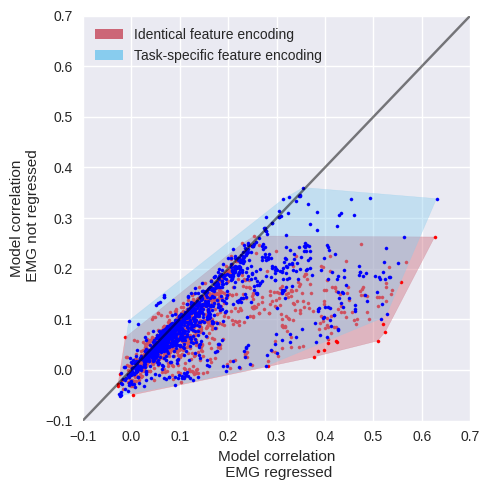

In [6]:
# Panel A
fig = plt.figure(figsize=(5,5))
corr_min,corr_max = -.1,.7
plt.xlabel('Model correlation\n EMG regressed')
plt.ylabel('Model correlation\n EMG not regressed')
# Regress EMG
xcorrs = np.hstack(list(corrs['model1'].values()))
ycorrs = np.hstack(list(corrs['model1e'].values()))
convex_hull(xcorrs,ycorrs,corr_min=corr_min,corr_max=corr_max,hull_color='#cc6677',hull_alpha=0.4)
plt.scatter(xcorrs,ycorrs,s=5,color='red')
plt.bar(0,0,color='#cc6677',label="Identical feature encoding")
# Don't regress EMG
xcorrs = np.hstack(list(corrs['model2'].values()))
ycorrs = np.hstack(list(corrs['model2e'].values()))
convex_hull(xcorrs,ycorrs,corr_min=corr_min,corr_max=corr_max,hull_color='#88ccee',hull_alpha=0.4)
plt.scatter(xcorrs,ycorrs,s=5,color='blue');
plt.bar(0,0,color='#88ccee',label='Task-specific feature encoding')
plt.plot([corr_min,corr_max],[corr_min,corr_max],color='k',alpha=0.5)

plt.legend()
plt.tight_layout()

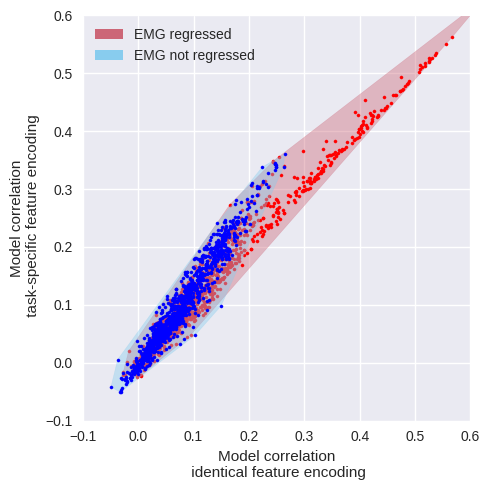

In [7]:
# Panel B
fig = plt.figure(figsize=(5,5))
corr_min,corr_max = -.1,.6
plt.xlabel('Model correlation\n identical feature encoding')
plt.ylabel('Model correlation\n task-specific feature encoding')
# Regress EMG
xcorrs = np.hstack(list(corrs['model1'].values()))
ycorrs = np.hstack(list(corrs['model2'].values()))
convex_hull(xcorrs,ycorrs,corr_min=corr_min,corr_max=corr_max,hull_color='#cc6677',hull_alpha=0.4)
plt.scatter(xcorrs,ycorrs,s=5,color='red')
plt.bar(0,0,color='#cc6677',label="EMG regressed")
# Don't regress EMG
xcorrs = np.hstack(list(corrs['model1e'].values()))
ycorrs = np.hstack(list(corrs['model2e'].values()))
convex_hull(xcorrs,ycorrs,corr_min=corr_min,corr_max=corr_max,hull_color='#88ccee',hull_alpha=0.4)
plt.scatter(xcorrs,ycorrs,s=5,color='blue');
plt.bar(0,0,color='#88ccee',label='EMG not regressed')
plt.legend()
plt.tight_layout()